<a href="https://colab.research.google.com/github/anhduong77/Credit-Scoring-ML-project/blob/main/notebooks/4_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/project/data/train_data.csv', index_col='issue_d', low_memory=False)
test_df = pd.read_csv('/content/drive/MyDrive/project/data/test_data.csv', index_col='issue_d', low_memory=False)

In [ ]:
print("Train data review:")
display(train_df.head(2))
print("Test data review:")
display(test_df.head(2))

Train data review:


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,is_cash_disbursement_mt
issue_d,,,,,,,,,,,,,,,,,,,,,
2013-01,1200.0,1200.0,1200.0,36,18.75,donaldson company,10+ years,MORTGAGE,60460.56,Not Verified,...,4.0,95.0,100.0,0.0,0.0,177544.0,28918.0,5900.0,28344.0,1
2013-01,19600.0,19600.0,19550.0,60,21.98,MD STAT URGENT CARE,3 years,RENT,51000.00,Source Verified,...,0.0,100.0,66.7,0.0,0.0,37628.0,26868.0,8000.0,29628.0,1


Test data review:


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,is_cash_disbursement_mt
issue_d,,,,,,,,,,,,,,,,,,,,,
2017-01,35000.0,35000.0,35000.0,60,23.99,Production Supervisor,8 years,RENT,78000.0,Source Verified,...,2.0,100.0,66.7,0.0,0.0,148388.0,52386.0,16400.0,57788.0,1
2017-01,35000.0,35000.0,35000.0,36,13.49,Owner,8 years,RENT,85000.0,Verified,...,1.0,100.0,25.0,0.0,0.0,61277.0,38833.0,36000.0,23577.0,1


In [ ]:
tar_col = 'loan_status'
num_cols = train_df.select_dtypes(include='number').columns.tolist()
cat_cols = train_df.select_dtypes(exclude='number').columns.tolist()
num_cols.remove(tar_col)

In [ ]:
bk_train_df = train_df.copy()
bk_test_df = test_df.copy()

# Feature Engineering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
high_card_cols = {'emp_title': 10, 'title': 10, 'addr_state': 3}
mapping_dict = {}
for col in high_card_cols:
  # Vectorize job titles
  vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

  if col == 'addr_state':
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train = encoder.fit_transform(train_df[col].values.reshape(-1, 1))
    X_test = encoder.transform(test_df[col].values.reshape(-1, 1))
  else:
    X_train = vectorizer.fit_transform(train_df[col].fillna("").astype(str))
    X_test = vectorizer.transform(test_df[col].fillna("").astype(str))
  # Cluster into, say, 1
  kmeans = KMeans(n_clusters=high_card_cols[col], random_state=42)
  train_col = kmeans.fit_predict(X_train).tolist()
  mapping_dict[col] = dict(zip(train_df[col], train_col))
  train_df[col] = train_col
  test_df[col] = kmeans.predict(X_test)

num_cols += high_card_cols.keys()
cat_cols = [x for x in cat_cols if x not in high_card_cols]

# Pipeline

In [ ]:
X_train, y_train = train_df[num_cols + cat_cols], train_df[tar_col]
X_test, y_test = test_df[num_cols + cat_cols], test_df[tar_col]

## woe transformer

In [ ]:
!pip install optbinning -q > /dev/null
from optbinning import OptimalBinning

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 5.26.1 which is incompatible.


In [ ]:
class WoeTransformer(BaseEstimator, TransformerMixin):
  def __init__ (self):
    self.binning_dict = {}
  def fit(self, X, y=None):
    X_num = X.select_dtypes(include='number')
    X_cat = X.select_dtypes(exclude='number')
    binning_num = [OptimalBinning(name=col, dtype="numerical").fit(X_num[col], y) for col in X_num.columns]
    binning_cat = [OptimalBinning(name=col, dtype="categorical", prebinning_method="cart", monotonic_trend=None).fit(X_cat[col], y) for col in X_cat.columns]
    num_dict = dict(zip(X_num.columns, binning_num))
    cat_dict = dict(zip(X_cat.columns, binning_cat))
    self.binning_dict = num_dict | cat_dict
    return self
  def transform(self, X):
    X_transformed = X.copy()
    for col in X_transformed.columns:
      X_transformed[col] = self.binning_dict[col].transform(X_transformed[col], metric="woe")
    return X_transformed


In [ ]:
class CatWoeTransformer(BaseEstimator, TransformerMixin):
  """
    attributes: woe_dict, columns
  """
  def __init__(self, columns):
    self.woe_dict_ = {}
    self.columns = columns
    self.woe_encoder = WoEEncoder(
    variables=columns,
    ignore_format=True,
    )
  def fit(self, X, y):

    event_df = X.copy()
    event_df['target'] = y
    cat_iv_dict = []
    self.woe_encoder.fit(X, y)
    for col in self.columns:
      col_df = event_df.groupby(by=col)['target'].agg(['sum', 'count'])
      total_events = col_df['sum'].sum(); total_non_events = (col_df['count'] - col_df['sum']).sum()
      if total_events == 0: total_events = 1
      if total_non_events == 0: total_non_events = 1
      col_df['event'] = col_df['sum'] / total_events
      col_df['non_event'] = (col_df['count'] - col_df['sum']) / total_non_events
      col_df['woe'] = col_df.index
      col_df['woe'] = col_df['woe'].map(self.woe_encoder.encoder_dict_[col])
      col_df['iv'] = (col_df['event'] - col_df['non_event']) * col_df['woe']
      col_df.loc['total'] = col_df.sum()
      self.woe_dict_[col] = col_df
    return self
  def transform(self, X):
    X_tfm = self.woe_encoder.transform(X)
    return X_tfm






In [ ]:
class DataFrameWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.training_data = None
    def fit(self, X, y=None):
      self.trainning_data = pd.DataFrame(X, columns=self.columns)
      return self
    def transform(self, X):
      return pd.DataFrame(X, columns=self.columns)

- Data pipeline

In [ ]:
!pip install feature_engine -q > /dev/null
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from feature_engine.encoding import RareLabelEncoder, WoEEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

rare_ecd_cols = ['purpose', 'home_ownership']
unecd_cols = [x for x in cat_cols if x not in rare_ecd_cols]
cat_cols = rare_ecd_cols + unecd_cols
woe_encoder = WoEEncoder(
        variables=cat_cols,
        ignore_format=True,
    )
cat_woe_tfmer = Pipeline(steps=[
    ('rare_encoder', RareLabelEncoder(
        tol=0.1,
        n_categories=2,
        variables=rare_ecd_cols,
        missing_values='ignore',
        ignore_format=True,
    )),

    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('to_frame', DataFrameWrapper(columns = cat_cols)),

    ('cat_woe_tfmer', CatWoeTransformer(columns=cat_cols))
])


num_woe_tfmer = WoeTransformer()
woe_transformer = ColumnTransformer(transformers=[('categorical', cat_woe_tfmer, cat_cols),
                                              ('numerical', num_woe_tfmer, num_cols)],
                                    remainder='drop')

In [ ]:
X_train_tf, X_test_tf = X_train.copy(), X_test.copy()
X_train_tf[cat_cols+num_cols] = woe_transformer.fit_transform(X_train, y_train.tolist())
X_test_tf[cat_cols+num_cols] = woe_transformer.transform(X_test)

- Distribution after transformation

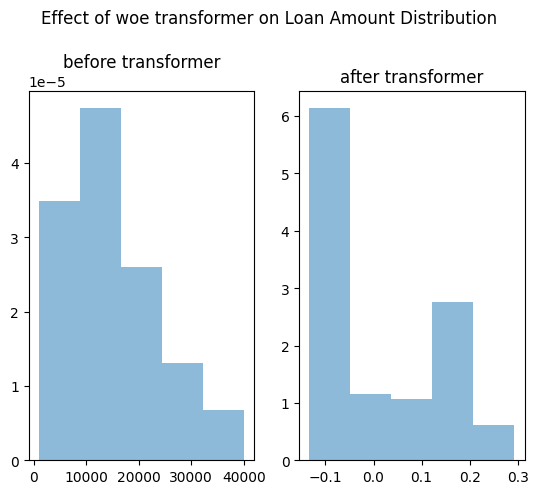

In [ ]:
fig, axes = plt.subplots(1, 2 )
axes[0].hist(X_train['loan_amnt'], bins=5, alpha=0.5, label="Data 1", density=True)
axes[1].hist(X_train_tf['loan_amnt'], bins=5, alpha=0.5, label="Data 2", density=True)
axes[0].set_title('before transformer')
axes[1].set_title('after transformer')
plt.suptitle("Effect of woe transformer on Loan Amount Distribution", fontsize=12,  y=1.05)
plt.show()


- In general, woe transformer completely change the distribution of data

In [ ]:
# data sparsity
print("Sparsity evaluation:")
print("Percent of sparsity in train data:", f'{((X_train_tf == 0).sum().sum() / (X_train_tf.shape[0] * X_train_tf.shape[1])) * 100:.2}%')
print("Percent of sparsity in test data:", f'{((X_test_tf == 0).sum().sum() / (X_test_tf.shape[0] * X_test_tf.shape[1])) * 100:.2}%')

Sparsity evaluation:
Percent of sparsity in train data: 0.32%
Percent of sparsity in test data: 0.37%


- Monotonic woe evaluation


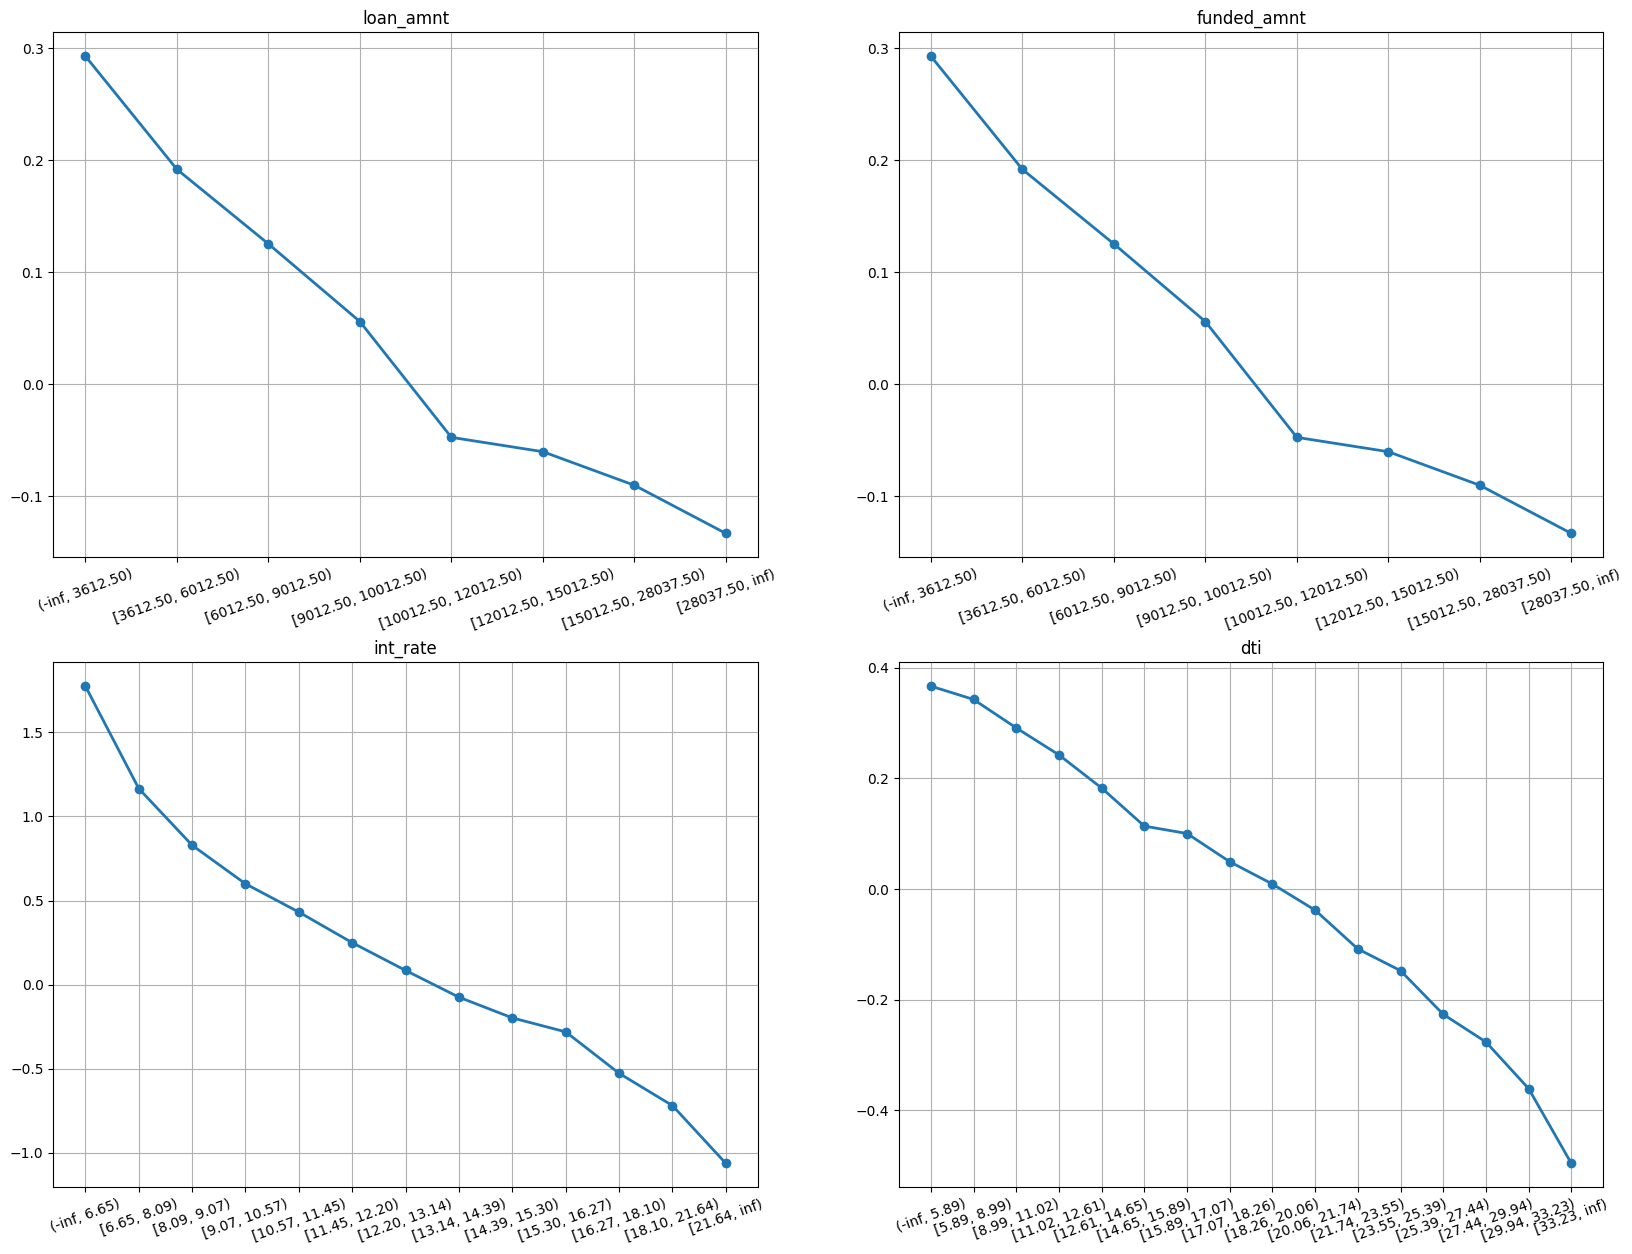

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(20, 15))
plt_features = ['loan_amnt', 'funded_amnt', 'int_rate', 'dti']
canvas = [axes[0, 0], axes[0, 1],
                  axes[1, 0], axes[1, 1]]
for index, feature in enumerate(plt_features):
  woe_loan = woe_transformer.named_transformers_['numerical'].binning_dict[feature].binning_table.build()[:-3]
  canvas[index].plot(woe_loan['Bin'], woe_loan['WoE'].astype(float), marker="o", linestyle="-", linewidth=2, markersize=6, color="#1f77b4")
  canvas[index].grid()
  canvas[index].tick_params(axis='x', rotation=20)
  canvas[index].set_title(feature)

# axes[0, 1].plot(woe_)

## scale transformer
- just scale the numerical features into a specific range not change the whole distribution

In [ ]:

# Preprocessors
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),   # Fill missing values with mean
    ('scaler', StandardScaler())                  # Scale numerical data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode categorical data
])

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
                                  'term', 'int_rate', 'annual_inc', 'zip_code',
                                  'dti', 'delinq_2yrs', 'fico_range_low',
                                  'fico_range_high', 'inq_last_6mths',
                                  'open_acc', 'pub_rec', 'revol_bal',
                                  'revol_util', 'total_acc',
                                  'is_whole_initial_li...
                                  'tot_coll_amt', 'tot_cur_bal',
                                  'total_rev_hi_lim', 'acc_open_past_24mths',
                                  'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
                                  'chargeoff_within_12_mths', 'delinq_amnt', ...]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['purpose', 'home_ownership', 'emp_length',
                                  'verification_status'])])

In [ ]:
X_train_tf_2 = preprocessor.fit_transform(X_train)
X_test_tf_2 = preprocessor.transform(X_test)

In [ ]:
# numerical transformer
num_train_tf_2, num_test_tf_2 = X_train[num_cols].copy(), X_test[num_cols].copy()
num_train_tf_2[num_cols] = numerical_transformer.fit_transform(X_train[num_cols])
num_test_tf_2[num_cols] = numerical_transformer.transform(X_test[num_cols])

# categorical transformer
cat_train_tf_2 = categorical_transformer.fit_transform(X_train[cat_cols])
cat_test_tf_2 = categorical_transformer.transform(X_test[cat_cols])

- Evaluate distribution of numerical features after transformer

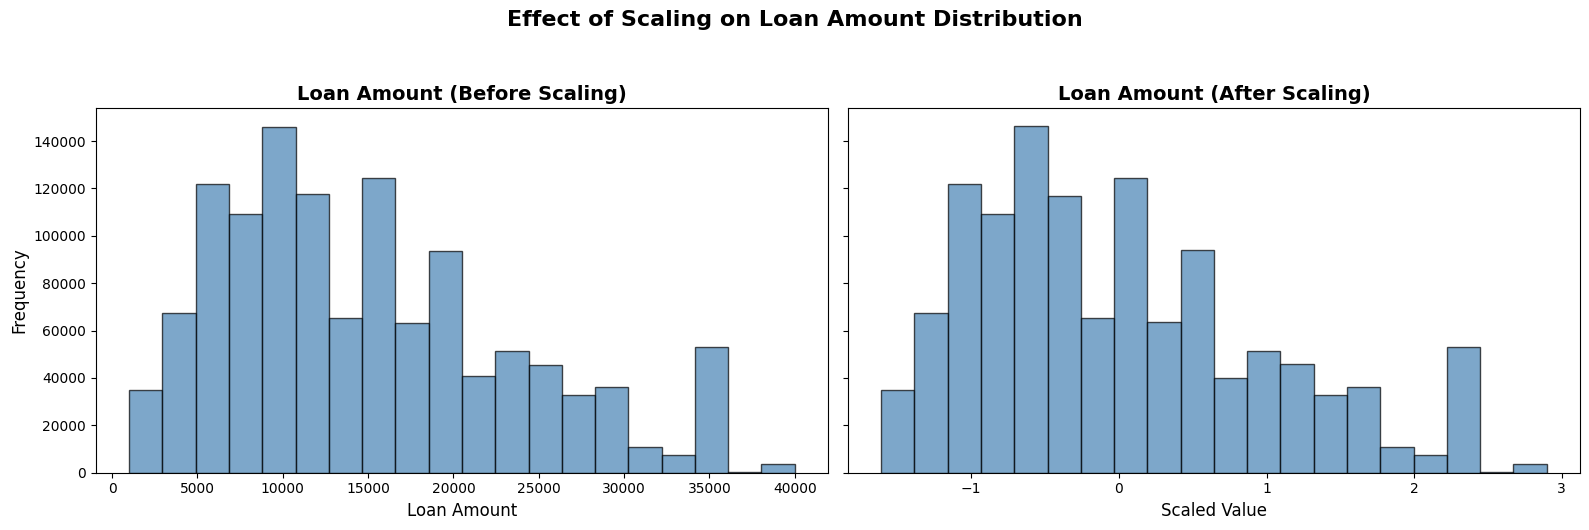

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Before scaling
axes[0].hist(X_train['loan_amnt'], bins=20, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].set_title("Loan Amount (Before Scaling)", fontsize=14, weight="bold")
axes[0].set_xlabel("Loan Amount", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# After scaling
axes[1].hist(num_train_tf_2['loan_amnt'], bins=20, color="steelblue", edgecolor="black", alpha=0.7)
axes[1].set_title("Loan Amount (After Scaling)", fontsize=14, weight="bold")
axes[1].set_xlabel("Scaled Value", fontsize=12)

# Overall layout
plt.suptitle("Effect of Scaling on Loan Amount Distribution", fontsize=16, weight="bold", y=1.05)
plt.tight_layout()
plt.show()

- In general, the standard scaler just scale the data to force it into a specific range not change the whole distribution

- Evaluate categorical features after transformer

In [ ]:
sp_train = ((cat_train_tf_2 == 0).sum() / (cat_train_tf_2.shape[0] * cat_train_tf_2.shape[1])) * 100
new_cols = cat_train_tf_2.shape[1] - len(cat_cols)
print(f'sparsity of data in train set: {sp_train:.2f}%')
sp_test = ((cat_test_tf_2 == 0).sum() / (cat_test_tf_2.shape[0] * cat_train_tf_2.shape[1])) * 100
print(f'sparsity of data in train set: {sp_test:.2f}%')
print(f'There are {new_cols} additional columns after transformation')

sparsity of data in train set: 87.50%
sparsity of data in train set: 87.50%
There are 28 additional columns after transformation


# Model
- **Metrics**: roc auc score is the metric that I use to compare how strong among the models since the dataset is unbalanced the metric like accuracy can be mislead.
- Threshold evaluation:
Score Range 	Description
| Score range | Description |
|---|---|
|0.9–1.0 |	Excellent discriminatory power|
|0.8–0.9| 	Good ability to classify default probability|
|0.7–0.8 |	Acceptable level of discrimination|
|0.6–0.7 |	Low ability to identify potential defaulters|
|0.5–0.6 |	Ineffective credit scoring model|

- Reference: https://riskseal.io/glossary/auc-area-under-curve
- Besides the roc-auc score. The metrics which are suitable for the classification problem is accuracy, precision, recall and f1-score.
- **Models**
Models, which are suitable for binary classificaiton problem, are logistic regression, xgboost, CatBoost, LightGBM
- Weakness vs Strength:
  + Logistic Regression:
    + Strength: suitable for problem needed high interpretability. It's easier to understand why model concludes the label.
    + Weakness: performance normally is lower compared to blackbox model \
                require plenty of constraints in dataset(for example, the relationship between each feature and target need to be linear, if it's not then logistic regression can be high bias - too simple for the dataset pattern)
  + Black-box models (xgboost, catboost, lightgbm):
    + Strength: high performance especially with a diverse dataset (million rows)
    + Weakness: hard to interpret or hard to understand why model decides the label.

=> As a results, I predict that black-box models will have better roc-auc score compared to logistic regression
    



In [ ]:
# logistic model
from sklearn.linear_model import LogisticRegression

lr_model_1 = LogisticRegression(
    penalty='l1',
    class_weight='balanced',
    solver='saga',
    C=1.0,
    max_iter=10000
)
lr_model_2 = LogisticRegression(
    penalty='l1',
    class_weight='balanced',
    solver='saga',
    C=1.0,
    max_iter=10
)
# xgboost
!pip install xgboost -q > /dev/null
import xgboost as xgb
xg_model_1 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=10,  # if data is imbalanced
    use_label_encoder=False,
    eval_metric='auc'
)
xg_model_2 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=10,  # if data is imbalanced
    use_label_encoder=False,
    eval_metric='auc'
)

!pip install catboost -q > /dev/null
from catboost import CatBoostClassifier, Pool
cat_model_1 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=200
)

cat_model_2 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=200
)

!pip install lightgbm -q > /dev/null
import lightgbm as lgb
lgb_model_1 = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=1000,
    random_state=42,
    metric='auc'
)
lgb_model_2 = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=1000,
    random_state=42,
    metric='auc'
)


In [ ]:
models = [lr_model_1, xg_model_1, cat_model_1, lgb_model_1,
                  lr_model_2, xg_model_2, cat_model_2, lgb_model_2]

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, accuracy_score

results = []
y_prob_ls = []
for index, model in enumerate(models):
  if index >= 4: training_data, testing_data, tfmer = X_train_tf_2, X_test_tf_2, 'StandardScaler'
  else: training_data, testing_data, tfmer = X_train_tf, X_test_tf, 'woe_transformer'
  model.fit(training_data, y_train)
  y_prob = model.predict_proba(testing_data)[:, 1]
  y_pred = model.predict(testing_data)
  y_prob_ls.append(y_prob)
  results.append({'model_names': model.__class__.__name__, 'transform_type' : tfmer,
                  'accuracy' : accuracy_score(y_test, y_pred), 'recall' : recall_score(y_test, y_pred),
                  'precision': precision_score(y_test, y_pred), 'f1_score': f1_score(y_test, y_pred),
                  'roc-auc_score' : roc_auc_score(y_test, y_prob)})


0:	total: 181ms	remaining: 3m 1s
200:	total: 23.8s	remaining: 1m 34s
400:	total: 46.6s	remaining: 1m 9s
600:	total: 1m 10s	remaining: 46.5s
800:	total: 1m 34s	remaining: 23.4s
999:	total: 1m 57s	remaining: 0us
[LightGBM] [Info] Number of positive: 206230, number of negative: 1019715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 1225945, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168221 -> initscore=-1.598286
[LightGBM] [Info] Start training from score -1.598286
0:	total: 159ms	remaining: 2m 38s
200:	total: 25.8s	remaining: 1m 42s
400:	total: 51.1s	remaining: 1m 16s
600:	total: 1m 16s	remaining: 50.7s
800:	total: 1m 41s	remaining: 25.2s
999:	total: 2m 5s	remaining: 0us
[LightGBM] [Info]

In [ ]:
results = pd.DataFrame(results)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


def plot_auc_score_dist(tar_test, tar_pred_prob, ax1, ax2, model_name="Model"):

  #ROC Curve
  fpr, tpr, thresholds = roc_curve(tar_test, tar_pred_prob)
  roc_auc = roc_auc_score(tar_test, tar_pred_prob)
  ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
  ax1.plot([0, 1], [0, 1], 'k--', label='Random Choice')
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  ax1.set_title('ROC Curve')
  ax1.legend()

  df_rank = pd.DataFrame({
      'label': tar_test,
      'score': tar_pred_prob
  })
  sns.kdeplot(data=df_rank, x='score', hue='label', common_norm=True, multiple="fill", ax=ax2)
  ax2.set_xlim(0, 1)
  ax2.set_ylim(0, 1)
  ax2.set_title('Probability Score Distribution by True Label')


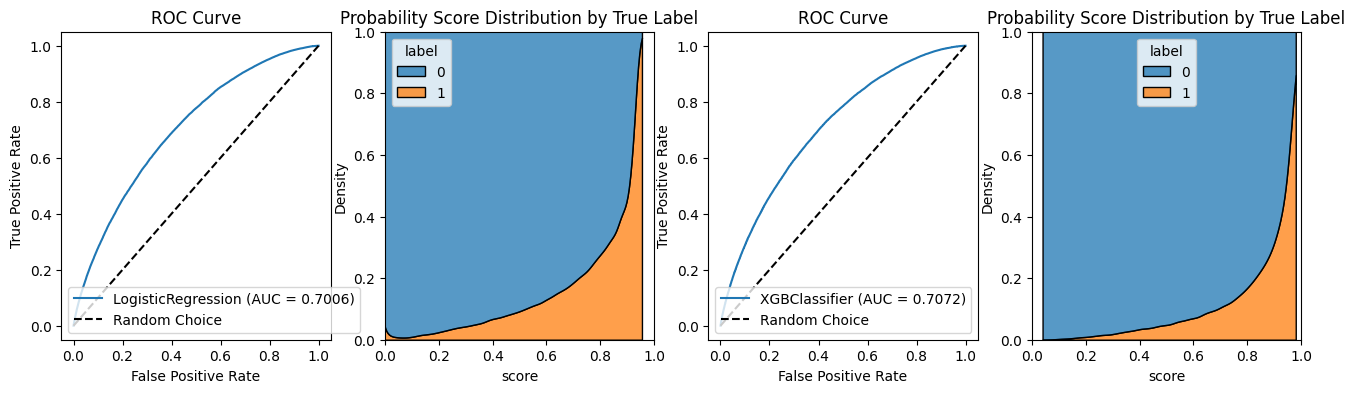

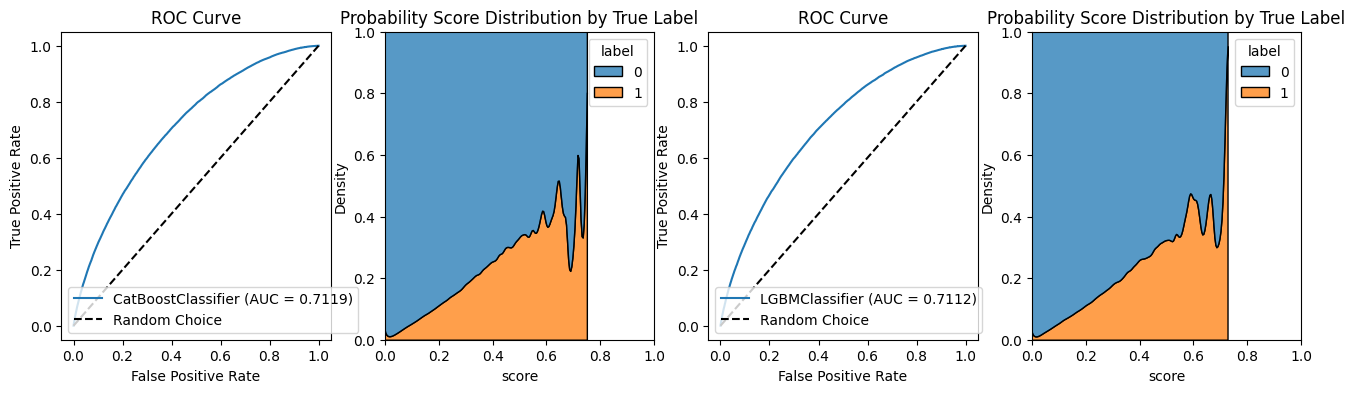

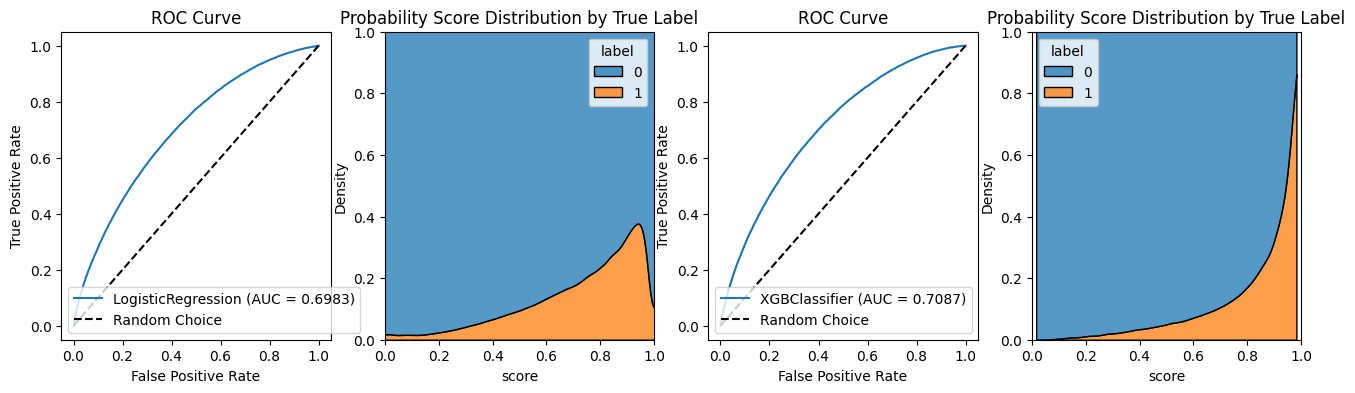

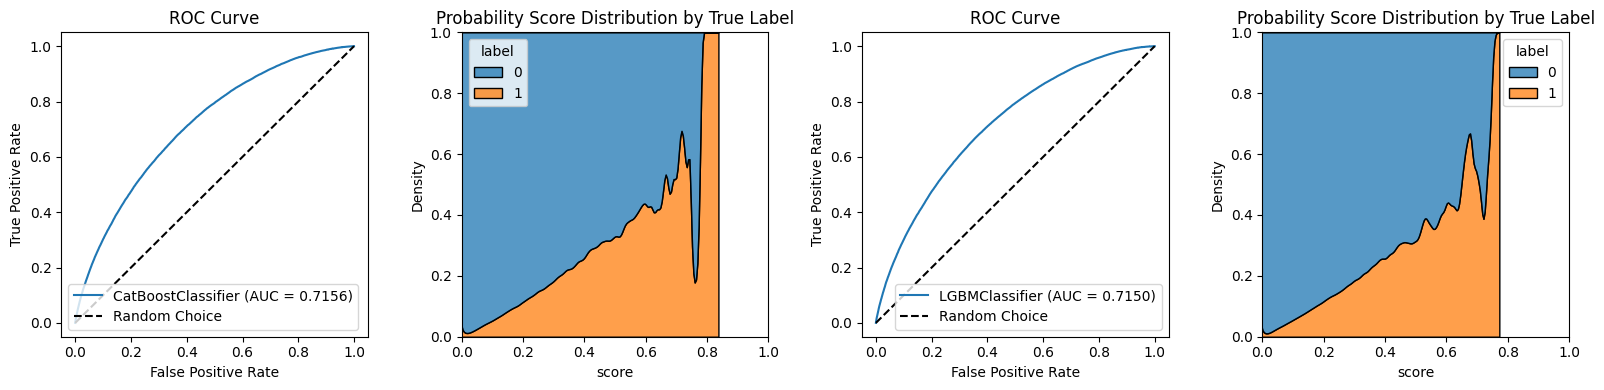

In [ ]:
for i in range(0, 8, 2):
  f, axes = plt.subplots(1, 4, figsize=(16, 4))
  plot_auc_score_dist(y_test, y_prob_ls[i], axes[0], axes[1], model_name=results.model_names[i])
  plot_auc_score_dist(y_test, y_prob_ls[i + 1], axes[2], axes[3], model_name=results.model_names[i + 1])
plt.tight_layout()
plt.show()

In [ ]:
results

,model_names,transform_type,accuracy,recall,precision,f1_score,roc-auc_score
0,LogisticRegression,woe_transformer,0.644922,0.643251,0.149252,0.242287,0.700641
1,XGBClassifier,woe_transformer,0.374179,0.900787,0.114130,0.202592,0.707181
2,CatBoostClassifier,woe_transformer,0.910451,0.017293,0.351141,0.032963,0.711928
3,LGBMClassifier,woe_transformer,0.910440,0.016987,0.348350,0.032394,0.711221
4,LogisticRegression,StandardScaler,0.665126,0.612854,0.152447,0.244160,0.698283
5,XGBClassifier,StandardScaler,0.379288,0.898360,0.114735,0.203481,0.708723
6,CatBoostClassifier,StandardScaler,0.910433,0.021023,0.369390,0.039782,0.715565
7,LGBMClassifier,StandardScaler,0.910474,0.020384,0.369444,0.038637,0.714999


- According to roc auc score, the model having highest performance is LGBMClassifier with woe_transformer type: 0.713812

# Analysis

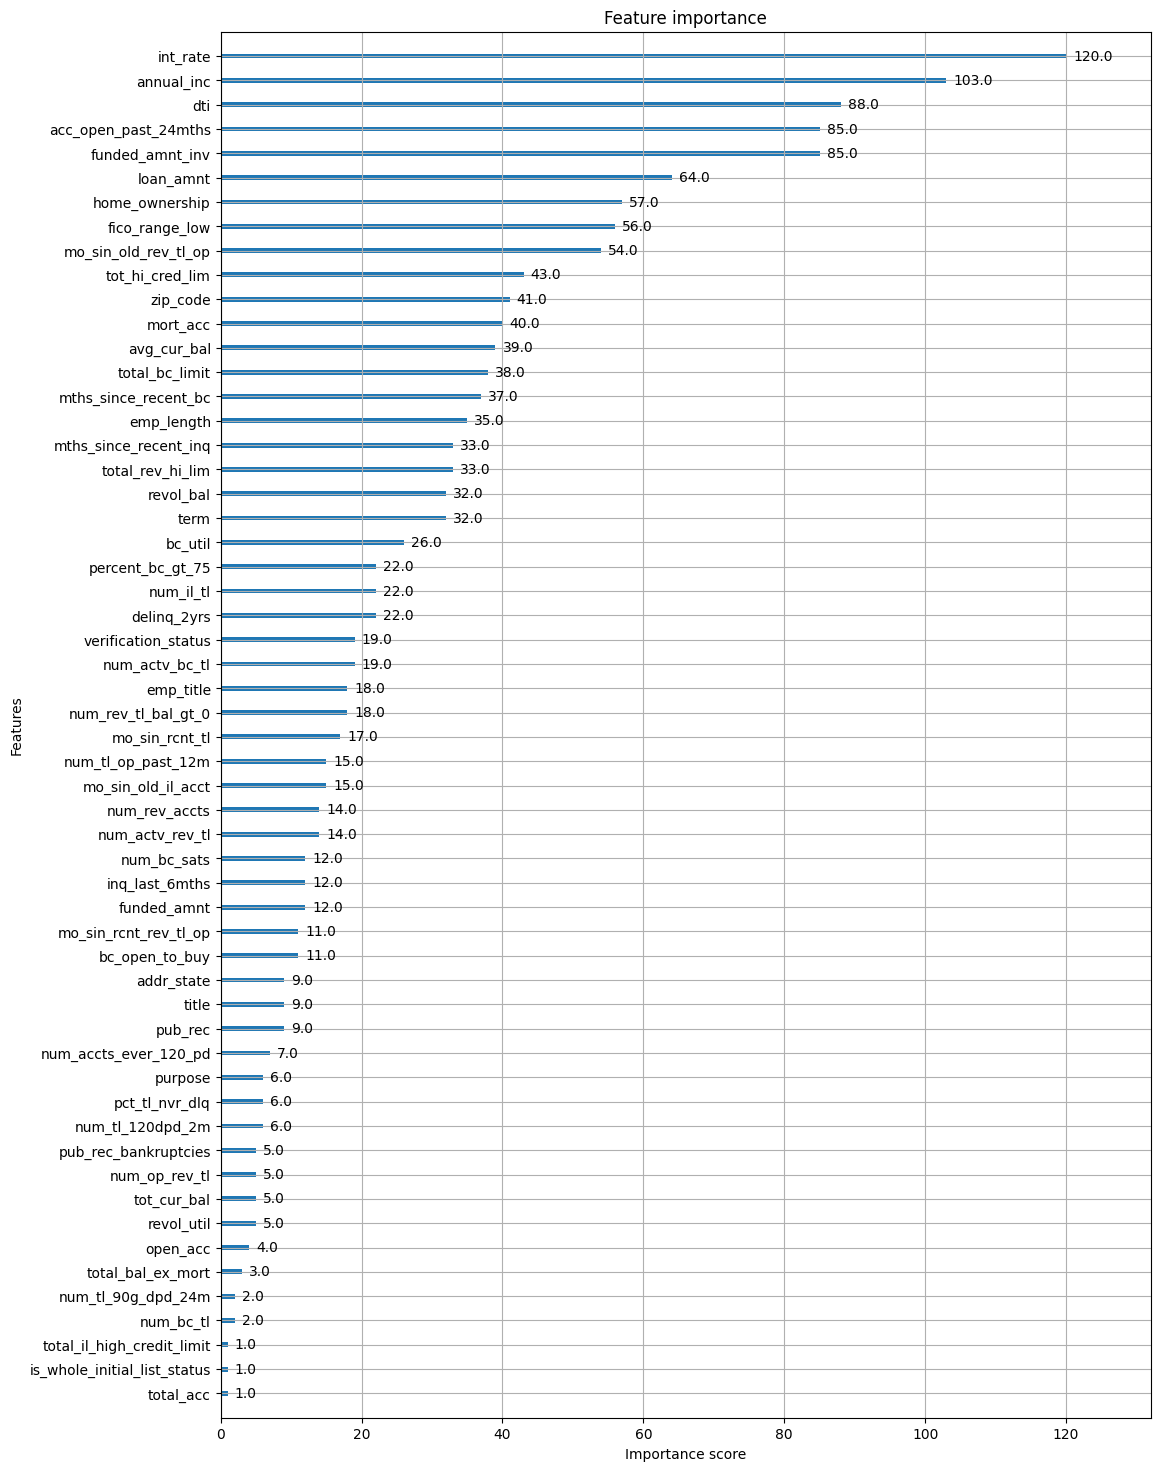

In [ ]:
# xgboost model
ax1 = xgb.plot_importance(xg_model_1)
fig1 = ax1.figure
fig1.set_size_inches(12, 18)
plt.show()

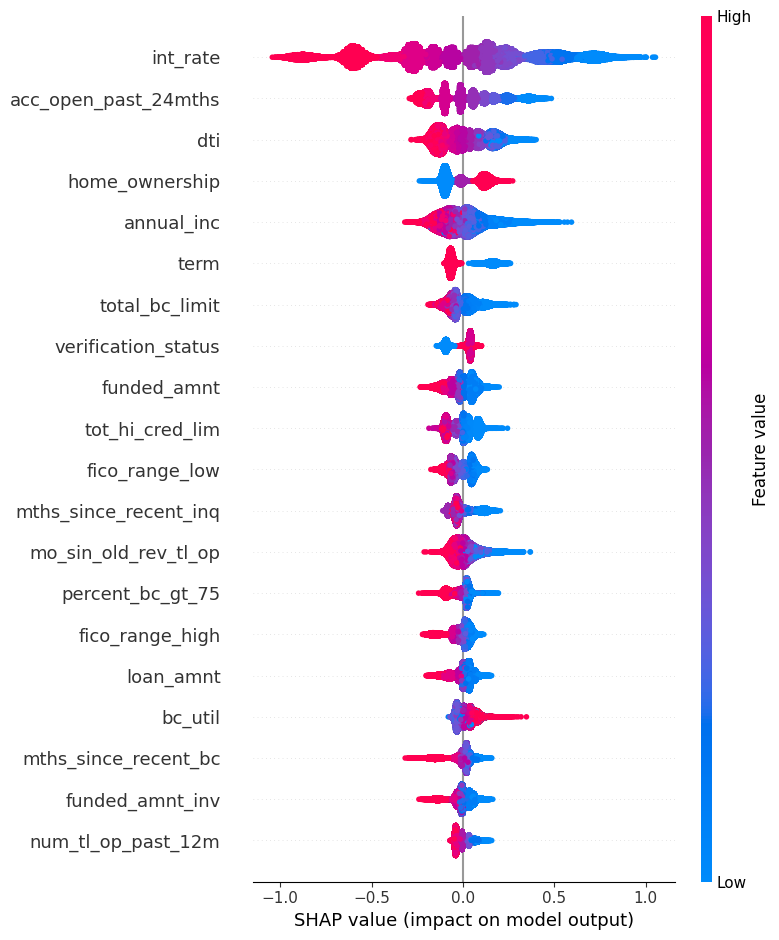

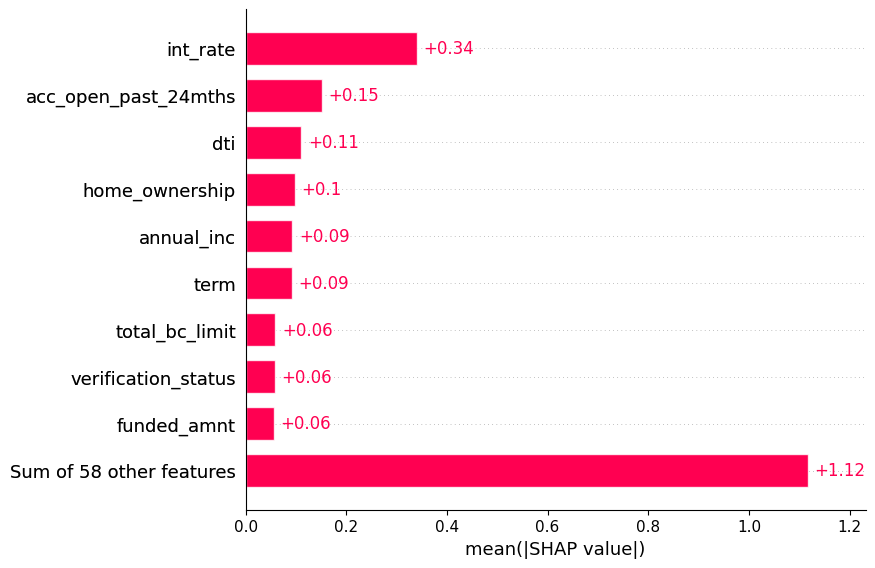

In [ ]:
!pip install shap -q > /dev/null
import shap

explainer = shap.Explainer(cat_model_1)
shap_values = explainer(X_test_tf)
shap.summary_plot(shap_values, X_test_tf)
shap.plots.bar(shap_values)

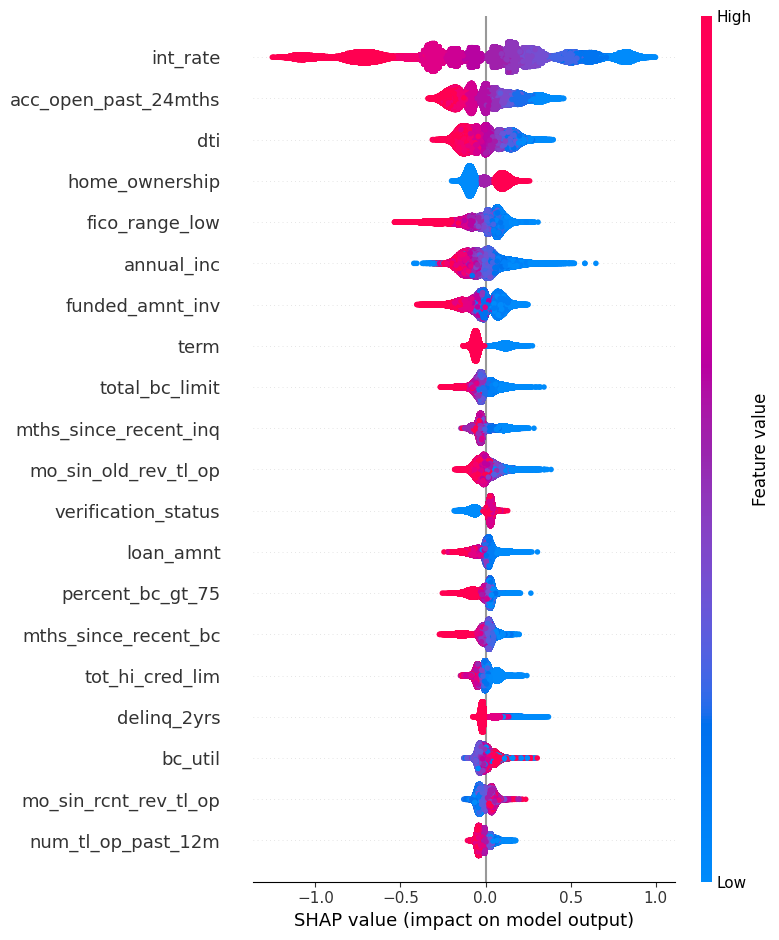

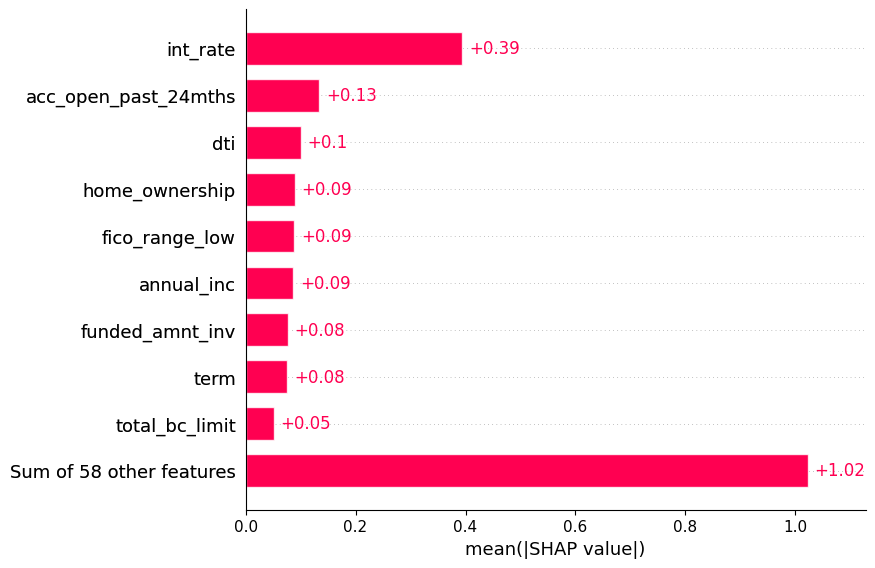

In [ ]:
explainer = shap.Explainer(lgb_model_1)
shap_values = explainer(X_test_tf)
shap.summary_plot(shap_values, X_test_tf)
shap.plots.bar(shap_values)

In [ ]:
pd.options.display.max_rows = 1000
lr_coef = pd.DataFrame({'features': X_train_tf.columns,
              'coef': lr_model_1.coef_[0]})
lr_coef['coef_abs'] = lr_coef['coef'].abs()
lr_coef = lr_coef.sort_values(by='coef_abs', ascending=False)
lr_coef.head()

,features,coef,coef_abs
47,num_tl_120dpd_2m,-8.720130,8.720130
12,open_acc,1.758252,1.758252
8,delinq_2yrs,-1.629522,1.629522
40,num_bc_sats,-1.073801,1.073801
46,num_sats,-1.043185,1.043185


In [ ]:
# iv for numerical columns
woe_transformer.named_transformers_['numerical'].binning_dict['loan_amnt'].binning_table.build().loc['Totals', 'IV']
binning_dict = woe_transformer.named_transformers_['numerical'].binning_dict
num_iv_dict = [{'features': feature,
                  'iv': binning_dict[feature].binning_table.build().loc['Totals', 'IV'].tolist()}
           for feature in binning_dict]
cat_woe_dict = woe_transformer.named_transformers_['categorical'][-1].woe_dict_
cat_iv_dict = [{'features': feature, 'iv': cat_woe_dict[feature].loc['total', 'iv'].tolist()} for feature in cat_woe_dict]
iv = num_iv_dict + cat_iv_dict
iv = pd.DataFrame(iv).sort_values(by='iv', ascending=False)
iv['iv_format'] = iv['iv'].apply(lambda x: f'{x:.2f}')

In [ ]:
pd.options.display.max_rows = 1000
iv.head(10)

,features,iv,iv_format
4,int_rate,0.424775,0.42
10,fico_range_high,0.116191,0.12
9,fico_range_low,0.116191,0.12
24,acc_open_past_24mths,0.092754,0.09
3,term,0.084009,0.08
50,num_tl_op_past_12m,0.069997,0.07
7,dti,0.060429,0.06
26,bc_open_to_buy,0.056330,0.06
66,verification_status,0.052139,0.05
25,avg_cur_bal,0.050967,0.05


In [ ]:
# So I will choose one of the top feature, corresponding to each model, to analyze
xg_test = X_test[: 2].copy(); cat_test = X_test[: 2].copy(); lgb_test = X_test[: 2].copy(); lr_test = X_test[: 2].copy()

# for xgboost model I will test to increase 1000 - 10000 in the annual_income
for i in range(1000, 100001, 1000):
  xg_test = pd.concat([xg_test, X_test.iloc[:2].copy()])
  xg_test.iloc[-2:]['annual_inc'] += i

# for catboost model I test to increase the number of opening account past 24 months
for i in range(1, 30, 1):
  cat_test = pd.concat([cat_test, X_test.iloc[:2].copy()])
  cat_test.iloc[-2:]['acc_open_past_24mths'] += i

lgb_test = pd.concat([lgb_test, X_test.iloc[:2].copy()])
lgb_test.iloc[-2:]['home_ownership'] = 'MORTGAGE'

for i in range(1, 50, 1):
  lr_test = pd.concat([lr_test, X_test.iloc[:2].copy()])
  lr_test.iloc[-2:]['dti'] += i
xg_prob = xg_model_1.predict_proba(woe_transformer.transform(xg_test))
cat_prob = cat_model_1.predict_proba(woe_transformer.transform(cat_test))
lgb_prob = lgb_model_1.predict_proba(woe_transformer.transform(lgb_test))
lr_prob = lr_model_1.predict_proba(woe_transformer.transform(lr_test))

xg_test = xg_test['annual_inc'].to_frame().copy()
xg_test['prob'] = xg_prob[:, 1]

cat_test = cat_test['acc_open_past_24mths'].to_frame().copy()
cat_test['prob'] = cat_prob[:, 1]

lgb_test = lgb_test['home_ownership'].to_frame().copy()
lgb_test['prob'] = lgb_prob[:, 1]

lr_test = lr_test['dti'].to_frame().copy()
lr_test['prob'] = lr_prob[:, 1]

In [ ]:
def cal_inc(arr):
  ls = arr.copy()
  row_0 = ls[0].copy(); row_1 = ls[1].copy()
  ls[0], ls[1] = 0, 0
  for i in range(2, len(ls)):
    if i % 2 == 0: ls[i] -= row_0
    else: ls[i] -= row_1
  return ls
xg_test = xg_test[['annual_inc', 'prob']]; cat_test = cat_test[['acc_open_past_24mths', 'prob']]
lgb_test = lgb_test[['home_ownership', 'prob']]; lr_test = lr_test[['dti', 'prob']]
xg_test['inc_annual_inc'] = cal_inc(xg_test['annual_inc']); xg_test['inc_prob'] = cal_inc(xg_prob[:, 1])
cat_test['inc_acc_open_past_24mths'] = cal_inc(cat_test['acc_open_past_24mths']); cat_test['inc_prob'] = cal_inc(cat_prob[:, 1])
lgb_test['inc_prob'] = cal_inc(lgb_prob[:, 1])
lr_test['inc_dti'] = cal_inc(lr_test['dti']); lr_test['inc_prob'] = cal_inc(lr_prob[:, 1])

In [ ]:
display(xg_test[:2])
display(xg_test[-4:])
display(cat_test[:2])
display(cat_test[-4:])
display(lgb_test[:2])
display(lgb_test[-4:])
display(lr_test[:2])
display(lr_test[-4:])

,annual_inc,prob,inc_annual_inc,inc_prob
issue_d,,,,
2017-01,78000.0,0.773615,0.0,0.0
2017-01,85000.0,0.700748,0.0,0.0


,annual_inc,prob,inc_annual_inc,inc_prob
issue_d,,,,
2017-01,177000.0,0.767067,99000.0,-0.006548
2017-01,184000.0,0.699034,99000.0,-0.001714
2017-01,178000.0,0.767067,100000.0,-0.006548
2017-01,185000.0,0.699034,100000.0,-0.001714


,acc_open_past_24mths,prob,inc_acc_open_past_24mths,inc_prob
issue_d,,,,
2017-01,2.0,0.198753,0.0,0.0
2017-01,3.0,0.177490,0.0,0.0


,acc_open_past_24mths,prob,inc_acc_open_past_24mths,inc_prob
issue_d,,,,
2017-01,30.0,0.198753,28.0,0.0
2017-01,31.0,0.177490,28.0,0.0
2017-01,31.0,0.198753,29.0,0.0
2017-01,32.0,0.177490,29.0,0.0


,home_ownership,prob,inc_prob
issue_d,,,
2017-01,RENT,0.238607,0.0
2017-01,RENT,0.165542,0.0


,home_ownership,prob,inc_prob
issue_d,,,
2017-01,RENT,0.238607,0.0
2017-01,RENT,0.165542,0.0
2017-01,RENT,0.238607,0.0
2017-01,RENT,0.165542,0.0


,dti,prob,inc_dti,inc_prob
issue_d,,,,
2017-01,21.20,0.839535,0.0,0.0
2017-01,14.46,0.415781,0.0,0.0


,dti,prob,inc_dti,inc_prob
issue_d,,,,
2017-01,69.20,0.846760,48.0,0.007226
2017-01,62.46,0.435578,48.0,0.019797
2017-01,70.20,0.846760,49.0,0.007226
2017-01,63.46,0.435578,49.0,0.019797


In [ ]:
# Overfitting and underfitting evaluation
for index, model in enumerate(models):
  training_data = X_train_tf_2
  if index < 4: training_data = X_train_tf
  results['roc_auc_train'] = roc_auc_score(y_train, model.predict_proba(training_data)[:, 1])

In [ ]:
results['roc_auc_diff'] = results['roc_auc_train'] - results['roc-auc_score']

In [ ]:
results

,model_names,transform_type,accuracy,recall,precision,f1_score,roc-auc_score,roc_auc_train,roc_auc_diff
0,LogisticRegression,woe_transformer,0.644922,0.643251,0.149252,0.242287,0.700641,0.745004,0.044363
1,XGBClassifier,woe_transformer,0.374179,0.900787,0.114130,0.202592,0.707181,0.745004,0.037823
2,CatBoostClassifier,woe_transformer,0.910451,0.017293,0.351141,0.032963,0.711928,0.745004,0.033076
3,LGBMClassifier,woe_transformer,0.910440,0.016987,0.348350,0.032394,0.711221,0.745004,0.033783
4,LogisticRegression,StandardScaler,0.665126,0.612854,0.152447,0.244160,0.698283,0.745004,0.046721
5,XGBClassifier,StandardScaler,0.379288,0.898360,0.114735,0.203481,0.708723,0.745004,0.036281
6,CatBoostClassifier,StandardScaler,0.910433,0.021023,0.369390,0.039782,0.715565,0.745004,0.029439
7,LGBMClassifier,StandardScaler,0.910474,0.020384,0.369444,0.038637,0.714999,0.745004,0.030005


- In general, the roc-auc-score difference between test data and train data range from 0.02 - 0.04. This's more likely the cost between moving from seen to unseen data so the model does not get overfitting.
- Regarding to underfitting cases, even the model that can generalize non-linear pattern data like tree-based model just get 0.72 - the highest auc - so I can conclude that most model does not get underfitting.

In [ ]:
def calculate_psi(base, compare, bins=10, cat_threshold=10):
    """
    Calculate PSI for a single feature (continuous or categorical).
    base: Series (baseline, e.g. train)
    compare: Series (comparison, e.g. test)
    bins: number of quantile bins for continuous features
    cat_threshold: max unique values to treat as categorical
    """
    base = pd.Series(base)
    compare = pd.Series(compare)

    if base.nunique(dropna=True) <= cat_threshold:
        categories = set(base.dropna().unique()) | set(compare.dropna().unique())
        base_counts = base.value_counts().reindex(categories, fill_value=0)
        compare_counts = compare.value_counts().reindex(categories, fill_value=0)
        # Add missing as a category
        base_counts["__missing__"] = base.isna().sum()
        compare_counts["__missing__"] = compare.isna().sum()

    else:
        quantiles = np.linspace(0, 1, bins+1)
        cut_points = np.unique(np.quantile(base.dropna(), quantiles))
        if len(cut_points) < 2:
            return 0.0  # constant feature
        base_counts, _ = np.histogram(base.dropna(), bins=cut_points)
        compare_counts, _ = np.histogram(compare.dropna(), bins=cut_points)
        # Add missing as a bucket
        base_counts = np.append(base_counts, base.isna().sum())
        compare_counts = np.append(compare_counts, compare.isna().sum())

    # Convert to proportions
    base_perc = base_counts / (base_counts.sum() + 1e-6)
    compare_perc = compare_counts / (compare_counts.sum() + 1e-6)

    psi = np.sum((compare_perc - base_perc) * np.log((compare_perc + 1e-6) / (base_perc + 1e-6)))
    return psi


In [ ]:
model_psi = []
for index, model in enumerate(models):
  training_data = X_train_tf; testing_data = X_test_tf
  if index >= 4: training_data = X_train_tf_2; testing_data = X_test_tf_2
  model_psi.append({'features': model.__class__.__name__,
                    'psi': calculate_psi(model.predict_proba(training_data)[:, 1], model.predict_proba(testing_data)[:, 1])})

In [ ]:
model_psi = pd.DataFrame(model_psi)
results['psi'] = model_psi['psi']

In [ ]:
results

,model_names,transform_type,accuracy,recall,precision,f1_score,roc-auc_score,roc_auc_train,roc_auc_diff,psi
0,LogisticRegression,woe_transformer,0.644922,0.643251,0.149252,0.242287,0.700641,0.745004,0.044363,0.014124
1,XGBClassifier,woe_transformer,0.374179,0.900787,0.114130,0.202592,0.707181,0.745004,0.037823,0.014713
2,CatBoostClassifier,woe_transformer,0.910451,0.017293,0.351141,0.032963,0.711928,0.745004,0.033076,0.015249
3,LGBMClassifier,woe_transformer,0.910440,0.016987,0.348350,0.032394,0.711221,0.745004,0.033783,0.015926
4,LogisticRegression,StandardScaler,0.665126,0.612854,0.152447,0.244160,0.698283,0.745004,0.046721,0.020943
5,XGBClassifier,StandardScaler,0.379288,0.898360,0.114735,0.203481,0.708723,0.745004,0.036281,0.021481
6,CatBoostClassifier,StandardScaler,0.910433,0.021023,0.369390,0.039782,0.715565,0.745004,0.029439,0.025836
7,LGBMClassifier,StandardScaler,0.910474,0.020384,0.369444,0.038637,0.714999,0.745004,0.030005,0.031702


- model using woe transformer likely to have a better psi, which means that they're more stable. This can result from the binning work which groups the outliers and extreme values to make it less affected on the model

In [ ]:
class EncodeHighCardFeatures(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.columns = high_card_cols.copy()
    self.dict = mapping_dict.copy()

  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X_tf = X.copy()
    for col in high_card_cols:
      if (col in X_tf.columns) and (col in self.dict):
        X_tf[col] = X_tf[col].map(self.dict[col])
    return X_tf

In [ ]:
final_pipeline = Pipeline(steps=[('encode_high_card', EncodeHighCardFeatures()),
                                ('woe_tfm', woe_transformer),
                                 ('model', lr_model_1)])

In [ ]:
X_train, y_train = bk_train_df.drop(tar_col, axis=1), bk_train_df[tar_col]
X_test, y_test = bk_test_df.drop(tar_col, axis=1), bk_test_df[tar_col]

In [ ]:
final_pipeline.fit(X_train, y_train.tolist())

Pipeline(steps=[('encode_high_card', EncodeHighCardFeatures()),
                ('woe_tfm',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('rare_encoder',
                                                                   RareLabelEncoder(ignore_format=True,
                                                                                    missing_values='ignore',
                                                                                    n_categories=2,
                                                                                    tol=0.1,
                                                                                    variables=['purpose',
                                                                                               'home_ownership'])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('to_frame',
                                                                   DataFrameW...
                                                   'is_whole_initial_list_status',
                                                   'collections_12_mths_ex_med',
                                                   'is_individual_app',
                                                   'acc_now_delinq',
                                                   'tot_coll_amt',
                                                   'tot_cur_bal',
                                                   'total_rev_hi_lim',
                                                   'acc_open_past_24mths',
                                                   'avg_cur_bal',
                                                   'bc_open_to_buy', 'bc_util',
                                                   'chargeoff_within_12_mths',
                                                   'delinq_amnt', ...])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    penalty='l1', solver='saga'))])

In [ ]:
from pathlib import Path
import joblib
joblib.dump(final_pipeline, "/content/drive/MyDrive/project/data/pipeline.joblib")
joblib.dump(mapping_dict, "/content/drive/MyDrive/project/data/mapping_dict.joblib")
X_test.iloc[X_test.index < '2017-02'].to_csv('/content/drive/MyDrive/project/data/deploit_testing.csv')

#Fine-tuning threshold
- Since P2P lending is a platform focusing more on profit. I will tune threshold at which model give the best profit for platform.
- Reference: [Idea approach](https://eprints.soton.ac.uk/403263/1/EMP_CS_SelfArchive.pdf)


In [ ]:
recoveries = pd.read_csv("/content/drive/MyDrive/project/data/test_recoveries.csv", index_col='issue_d')

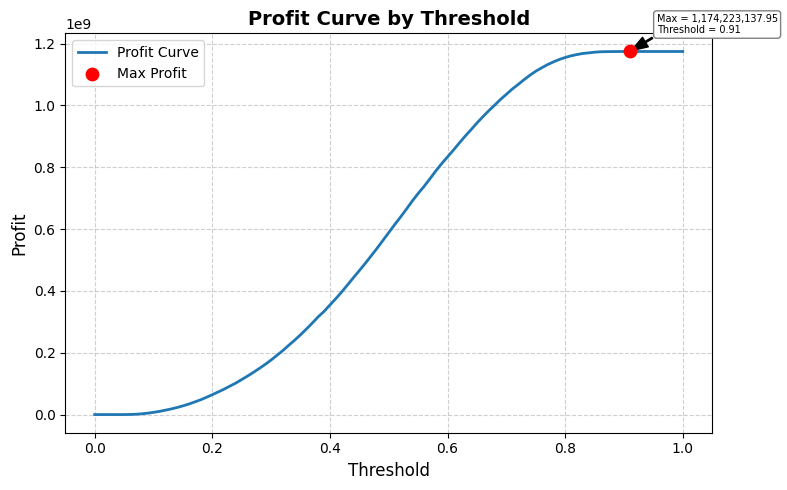

In [ ]:
y_proba = final_pipeline.predict_proba(X_test)[:, 1]
evol_df = {'y_true': y_test,
           'y_pred_prob': y_proba,
           'loan_amnt': test_df['loan_amnt'].tolist(),
           'int_rate': test_df['int_rate'].tolist(),
           'term': test_df['term'].tolist(),
           'recoveries': recoveries['recoveries'].tolist()}
evol_df = pd.DataFrame(evol_df)
# Monthly interest rate
evol_df['mth_int_rate'] = evol_df['int_rate'] / 100 / 12

# Monthly installment (PMT)
evol_df['mth_payment'] = evol_df['loan_amnt'] * (
    evol_df['mth_int_rate'] * (1 + evol_df['mth_int_rate'])**evol_df['term']
    / ((1 + evol_df['mth_int_rate'])**evol_df['term'] - 1)
)

# Total repayment (if no default)
evol_df['total_repayment'] = evol_df['mth_payment'] * evol_df['term']

# Profit given no default
evol_df['profit_given_non_default'] = evol_df['total_repayment'] - evol_df['loan_amnt']

# Loss given default
evol_df['loss_given_default'] = -1 * evol_df['loan_amnt'] + evol_df['recoveries']
profit = []
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:

  evol_df['y_pred'] = (evol_df['y_pred_prob'] > threshold).astype(int)
  if (len(evol_df[evol_df['y_pred'] == 0]) == 0):
    profit.append({'thresholds': threshold, 'profit': 0})
    continue
  pos_pred = evol_df[evol_df['y_pred'] == 0].copy()
  pos_pred = pos_pred.groupby(by='y_true').agg(profit_gv_non_df=('profit_given_non_default', 'sum'),
                                             losses_gv_df = ('loss_given_default', 'sum'))
  if len(pos_pred) == 2:
    profit.append({'thresholds': threshold.tolist(),
                  'profit': (pos_pred.iloc[0, 0] + pos_pred.iloc[1, 1]).tolist()})
  else:
    profit.append({'thresholds': threshold.tolist(),
                          'profit': pos_pred.iloc[pos_pred.index[0], pos_pred.index[0]]})
profit = pd.DataFrame(profit)
# Plot the profit curve
plt.figure(figsize=(8,5))
plt.plot(profit['thresholds'].tolist(), profit['profit'].tolist(), label="Profit Curve", linewidth=2)

# Find max profit
max_index = profit['profit'].idxmax()
x_max, y_max = profit.loc[max_index, 'thresholds'], profit.loc[max_index, 'profit']

# Highlight the max point
plt.scatter(x_max, y_max, color='red', s=80, zorder=5, label="Max Profit")
plt.annotate(f"Max = {y_max:,.2f}\nThreshold = {x_max:.2f}",
             xy=(x_max, y_max),
             xytext=(x_max*1.05, y_max*1.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=7, bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white"))

# Styling
plt.title("Profit Curve by Threshold", fontsize=14, fontweight="bold")
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Profit", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()